Initial data shape: (464, 57)
After dropping rows with excessive NaNs: (464, 57)
Input shape: (464, 5, 11)
Label classes: ['Average' 'Hold' 'Sell']
Computed class weights: {0: np.float64(0.424971363115693), 1: np.float64(7.729166666666667), 2: np.float64(1.9322916666666667)}
✅ Oversampling done. New training shape: (873, 5, 11)


c:\Python313\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 5, 11)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        38,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,139 (168.51 KB)

 Trainable params: 43,139 (168.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 - 31s - 623ms/step - accuracy: 0.3707 - loss: 2.9866 - val_accuracy: 0.0000e+00 - val_loss: 2.2707
Epoch 2/50
50/50 - 1s - 24ms/step - accuracy: 0.3707 - loss: 2.1333 - val_accuracy: 0.0000e+00 - val_loss: 1.9719
Epoch 3/50
50/50 - 1s - 22ms/step - accuracy: 0.3707 - loss: 2.0893 - val_accuracy: 0.0000e+00 - val_loss: 1.8317
Epoch 4/50
50/50 - 1s - 27ms/step - accuracy: 0.3707 - loss: 2.0650 - val_accuracy: 0.0000e+00 - val_loss: 1.8868
Epoch 5/50
50/50 - 1s - 27ms/step - accuracy: 0.3707 - loss: 2.0377 - val_accuracy: 0.0000e+00 - val_loss: 1.9766
Epoch 6/50
50/50 - 1s - 29ms/step - accuracy: 0.3847 - loss: 2.0255 - val_accuracy: 0.0000e+00 - val_loss: 2.0920
Epoch 7/50
50/50 - 2s - 30ms/step - accuracy: 0.3898 - loss: 1.9920 - val_accuracy: 0.0000e+00 - val_loss: 1.9814
Epoch 8/50
50/50 - 1s - 26ms/step - accuracy: 0.4000 - loss: 1.9729 - val_accuracy: 0.0000e+00 - val_loss: 1.7774
Epoch 9/50
50/50 - 1s - 27ms/step - accuracy: 0.4178 - loss: 1.9121 - val_accuracy: 0.

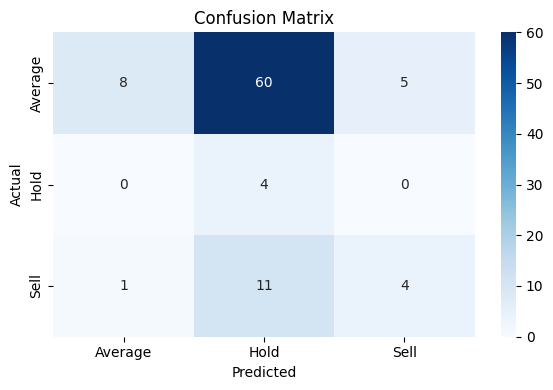


📊 Classification Report:
              precision    recall  f1-score   support

     Average       0.89      0.11      0.20        73
        Hold       0.05      1.00      0.10         4
        Sell       0.44      0.25      0.32        16

    accuracy                           0.17        93
   macro avg       0.46      0.45      0.21        93
weighted avg       0.78      0.17      0.21        93



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample

# Load dataset and filter invalid ratings
df = pd.read_excel("labeled_stocks_with_price.xlsx")
df = df[df['Rating'].isin(['Average', 'Hold', 'Sell'])]
print("Initial data shape:", df.shape)

# Drop rows with too many NaNs
df.dropna(thresh=50, inplace=True)
print("After dropping rows with excessive NaNs:", df.shape)

# Define structure
quarters = ['Mar 2024', 'Jun 2024', 'Sep 2024', 'Dec 2024', 'Mar 2025']
features = ['Sales+', 'Expenses', 'Operating Profit', 'OPM %', 'Other Income',
             'Net Profit', 'EPS in Rs']

# Prepare sequences
X, y = [], []
for stock in df['Stock'].unique():
    stock_data = df[df['Stock'] == stock]
    rating = stock_data.iloc[0].get('Rating')
    if pd.isna(rating):
        continue

    sequence = []
    for q in quarters:
        row = []
        for f in features:
            col_name = f"{q}_{f}"
            row.append(stock_data.iloc[0].get(col_name, np.nan))
        sequence.append(row)

    sequence = np.array(sequence)
    if np.isnan(sequence).sum() > 10:
        continue

    sequence = pd.DataFrame(sequence).ffill().bfill().values
    X.append(sequence)
    y.append(rating)

X = np.array(X)
y = np.array(y)
print("Input shape:", X.shape)

# Normalize
scaler = MinMaxScaler()
n_timesteps, n_features = X.shape[1], X.shape[2]
X_scaled = scaler.fit_transform(X.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Label classes:", label_encoder.classes_)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Compute class weights (based on original unbalanced data)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Computed class weights:", class_weights_dict)

# Optional: Oversample training data to further balance
X_train_balanced, y_train_balanced = [], []
unique_classes, counts = np.unique(y_train, return_counts=True)
max_count = max(counts)

for cls in unique_classes:
    idxs = np.where(y_train == cls)[0]
    X_cls = X_train[idxs]
    y_cls = y_train[idxs]

    X_res, y_res = resample(X_cls, y_cls, replace=True, n_samples=max_count, random_state=42)
    X_train_balanced.append(X_res)
    y_train_balanced.append(y_res)

X_train = np.concatenate(X_train_balanced)
y_train = np.concatenate(y_train_balanced)
print("✅ Oversampling done. New training shape:", X_train.shape)

# Build model
model = Sequential([
    Masking(mask_value=0., input_shape=(n_timesteps, n_features)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=2
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print("✅ Test Accuracy:", accuracy)

# Predict
y_pred = model.predict(X_test).argmax(axis=1)
labels = label_encoder.classes_

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels, zero_division=0))
